## CNN para identificar sospecha de leucemia en imágenes de células sanguíneas 

### En el siguiente Notebook se detallará la arquitectura de la red neuronal convolucional y las últimas pruebas ejecutadas, las cuales corresponden a los dos modelos que decidimos evaluar finalmente entre sí, así identificar cual de ellos tiene un mejor desempeño.

#### Dataset
- Total de imagenes: 7172 sospecha y 3389 normales, 10561 total.
- Dos grupos de imágenes de 3000 cada una (80% train y 20% test), total 6000 imagenes.
- Un tercer grupo de 2389 imagenes para validar

## Proceso:

### 1. Librerias y funciones para conversión imagenes de bmp a jpg y generación de arrays tanto de imagenes como de etiquetas.


In [19]:
#IMPORTAMOS LIBRERIAS
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, LeakyReLU

from tensorflow.keras.regularizers import l2 ,l1_l2
from keras.callbacks import EarlyStopping

from tensorflow.keras import losses
from tensorflow.keras import optimizers

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_curve, auc
import pandas as pd

- Paso 1: Convertir imágenes de bmp a jpg y guardar en una única carpeta/ruta , si ya tenemos convertidas las imágenes, declarar las variables y pasar al paso dos

In [2]:
#VARIABLES

#CARPETAS DE IMAGENES ORIGINALES- MODIFICAR RUTAS
train_blastos_images = '/Users/vanessabenites/Desktop/Personal/MASTER NEBRIJE/TFM/Corrida3/Blastos' 
train_normales_images = '/Users/vanessabenites/Desktop/Personal/MASTER NEBRIJE/TFM/Corrida3/Normales'

#CARPETA FINAL EN LA QUE SE GUARDAN IMÁGENES EN JPG
ruta_final = "/Users/vanessabenites/Desktop/Personal/MASTER NEBRIJE/TFM/Corrida3/ruta_final"

clase1 = "normal"
clase2= "sospecha"

In [25]:
#FUNCION CONVERTIR IMAGENES BMP A JPG
def convertir_jpg(carpeta,ruta_final,clase):

  #Directorio con imagenes originales
  imagenes = os.listdir(carpeta)

  count=0
  for imagen in imagenes :
    imagen_original_path = carpeta + "/" + imagen
    img_bmp = cv2.imread(imagen_original_path)
    if imagen is None:
      continue  

    #Etiquetado 
    img_jpg = cv2.imencode('.jpg', img_bmp)[1]
    cv2.imwrite(ruta_final + "/"+ clase + "_" + str(count) +".jpg",img_bmp)
    count +=1
    
  return print("ok")

#FUNCION CONVERTIR IMAGENES (normales)
convertir_jpg(train_normales_images,ruta_final,clase1)
#FUNCION CONVERTIR IMAGENES (blastos)
convertir_jpg(train_blastos_images,ruta_final,clase2)

ok
ok


- Paso 2 en este paso realizaremos 
. la creación de arrays de etiquetas y de imágenes
. Tratamiento de etiquetas:
      2.1 primero para prueba se imprimirá el array original de etiquetas , 
      2.2 cambiando a nombres normal y sospecha y 
      2.3 aplicando ONE HOT ENCODER
. Tratamiento de imágenes:
      2.4 Las imágenes han sido normalizadas
      2.5 Se reducen los píxeles de las imágenes y se guarda en una lista
      2.6 Se convierte la lista de imágenes en un array de imágenes

In [3]:
#FUNCION PARA CREAR LISTAS TANTO DE IMAGENES COMO DE ETIQUETAS RESPECTIVAMENTE
def armando_listas(ruta_final):

  imagenes = os.listdir(ruta_final) #INCLUIDO DESPUÉS
  #listas vacías tanto para las imagenes como para las etiquetas
  images_list = []
  labels_list = []

  for label in imagenes:
    labels_list.append(label)
    img_convertida_path = ruta_final + "/" + label
    img = cv2.imread(img_convertida_path)
    images_list.append(img)

  #Convertimos las listas a arrays
  images_array = np.array(images_list)
  labels_array = np.array(labels_list)
  return labels_array,images_array

#Guardo en una variable el resultado de la función (guarda una tupla primero)
array_completo=armando_listas(ruta_final)

# SEPARACIÓN DE ARRAYS IMÁGENES Y ETIQUETAS
etiquetas_array=array_completo[0] 
imagenes_array=array_completo[1]

print()
print("2.1 primero para prueba se imprimirá el array original de etiquetas", etiquetas_array)

# TENEMOS LAS IMÁGENES ETIQUETADAS COMO blasto_ O normal_, POR ESTO PRIMERO NOS TOCA CAMBIAR LOS NOMBRES A BLASTO Y NORMAL PARA LUEGO APLICAR ONE HOT ENCODER
char_replace_n = "normal"
replace_n = "normal"

char_replace_s = "sospecha_"
replace_s = "sospecha"

# Loop through the array and replace the strings containing the characters with the replacement string
for i in range(len(etiquetas_array)):
  if char_replace_n in etiquetas_array[i]:
        etiquetas_array[i] = replace_n
  if char_replace_s in etiquetas_array[i]:
        etiquetas_array[i] = replace_s

# Print the updated array of strings
print("2.2 cambiando a nombres normal y sospecha ", etiquetas_array)

#APLICANDO ONE HOT ENCODER
def encoder(etiquetas):
  le = LabelEncoder()
  # Fit and transform the categorical data using the LabelEncoder object
  etiquetas = le.fit_transform(etiquetas_array)
  # Print the original and encoded data
  print("2.3 APLICANDO ONE HOT ENCODER")
  print("Original categories:", etiquetas_array)
  print("Encoded categories:", etiquetas)
  return etiquetas

#FUNCION ONE HOT ENCODER
etiquetas=encoder(etiquetas_array) # GUARDAR EN UNA VARIABLE EL RESULTADO DE LA FUNCIÓN ONE HOT ENCODER

#NORMALIZANDO IMAGENES
def normalizar(imagenes):
  imagenes_normalizadas = np.array(imagenes).astype(float)/255

  return imagenes_normalizadas
#FUNCION NORMALIZAR
imagenes_normalizadas=normalizar(imagenes_array) #INCLUIDO , GUARDAR EN UNA VARIABLE EL RESULTADO DE LA FUNCIÓN
print("2.4 Las imágenes han sido normalizadas")

##reducción de píxeles
lista_nueva = []
tamano_imagen = 250  

for img in imagenes_normalizadas:
    imagen = cv2.resize(img,(tamano_imagen, tamano_imagen))
    lista_nueva.append(imagen)
    #Editar color de imagen
    #imagen = cv2.cvtcolor(imagen, cv2.COLOR_BGR2GRAY)
    #plt.subplot(2,5)
    #plt.xticks([])
    #plt.yticks([])
    #plt.imshow(imagen)
print("2.5 Reducción de píxeles de imágenes y guardar en una lista")
len(lista_nueva)
type(lista_nueva)

#NUEVO ARRAY DE IMAGENES CON MENOR NUMERO DE PIXELES (450 A 250 PIXELES)
array_img_nuevo = np.array(lista_nueva)
print("2.6 Se convierte la lista de imágenes en un array de imágenes, su tamaño es :" ,array_img_nuevo.shape)


2.1 primero para prueba se imprimirá el array original de etiquetas ['sospecha_1397.jpg' 'sospecha_588.jpg' 'sospecha_1383.jpg' ...
 'normal_333.jpg' 'sospecha_591.jpg' 'normal_327.jpg']
2.2 cambiando a nombres normal y sospecha  ['sospecha' 'sospecha' 'sospecha' ... 'normal' 'sospecha' 'normal']
2.3 APLICANDO ONE HOT ENCODER
Original categories: ['sospecha' 'sospecha' 'sospecha' ... 'normal' 'sospecha' 'normal']
Encoded categories: [1 1 1 ... 0 1 0]
2.4 Las imágenes han sido normalizadas
2.5 Reducción de píxeles de imágenes y guardar en una lista
2.6 Se convierte la lista de imágenes en un array de imágenes, su tamaño es : (2389, 250, 250, 3)


### 2. Split de datos

- División del dataset en train y test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(array_img_nuevo, etiquetas, test_size=0.2, random_state=42)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("etiquetas de test:",len(y_test))

Training set size: 2400
Testing set size: 600
etiquetas de test: 600


- Incremento de imágenes

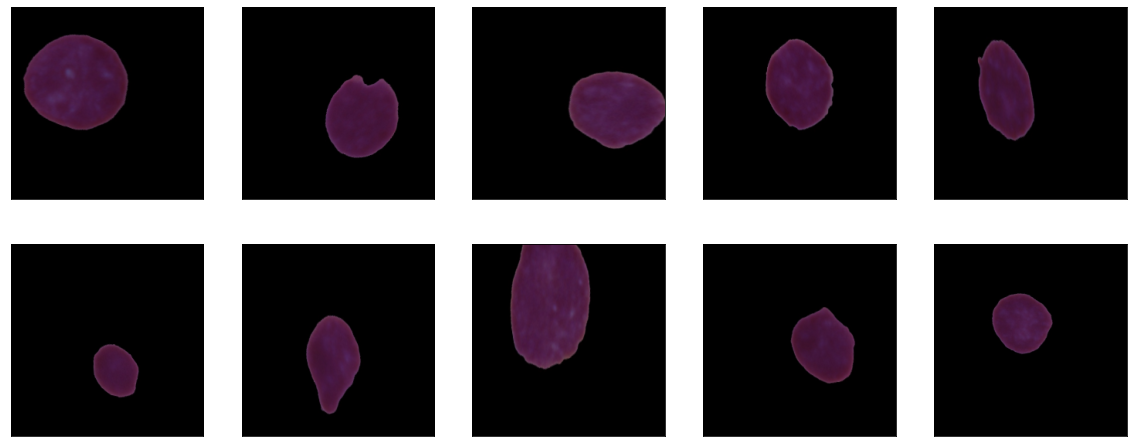

In [6]:
#Incremento de imágenes
#documentación: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen= ImageDataGenerator(
    rotation_range= 30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7,1.4],
    horizontal_flip=True,
    vertical_flip=True
)

plt.figure(figsize=(20,8))

for imagen, etiqueta in datagen.flow(X_train,y_train,batch_size=10,shuffle=False):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imagen[i])
    break

- Cálculo a partir de la longitud del array de train y validación (tanto x como y) y división del dataset 

In [7]:
Porcentaje_train= 0.7 #Si se requiere, cambiar 
tamanotrain=len(X_train)* Porcentaje_train 
print("el tamaño de entrenamiento es", tamanotrain)
tamanovalidation=len(X_train) -(len(X_train)* Porcentaje_train)
print("el tamaño de validacion es", tamanovalidation)

el tamaño de entrenamiento es 1680.0
el tamaño de validacion es 720.0


In [8]:
x_entrenamiento=X_train[:1680]
x_validacion=X_train[1680:]
y_entrenamiento=y_train[:1680]
y_validacion=y_train[1680:]

### 3. Construcción de Arquitecturas

## 👆 Modelo 7, Prueba1

In [16]:
# Cambiar el nombre del modelo con cada prueba realizada, modelo_dia_corrida_modelo_numprueba
modelo_5_1_1_1 = Sequential() 
#Add layers 
modelo_5_1_1_1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(250, 250, 3)))
modelo_5_1_1_1.add(MaxPooling2D(2, 2))
modelo_5_1_1_1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
modelo_5_1_1_1.add(MaxPooling2D(2, 2))
modelo_5_1_1_1.add(Conv2D(128, (3,3), activation='relu'))
modelo_5_1_1_1.add(MaxPooling2D(2, 2))
modelo_5_1_1_1.add(Conv2D(192, (3,3), activation='relu'))

modelo_5_1_1_1.add(Flatten())
modelo_5_1_1_1.add(Dense(100,activation= 'relu'))
modelo_5_1_1_1.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.01)))

#declare adam optimizer 
adam = optimizers.Adam(learning_rate = 0.1 )


#compile the model
modelo_5_1_1_1.compile(loss= "binary_crossentropy", optimizer = "adam", metrics= ["accuracy"]) 

In [17]:
early_stop_5_1_1_1 = EarlyStopping(monitor= "val_loss", patience=15, mode="min") 
data_gen_entrenamiento_5_1_1_1= datagen.flow(x_entrenamiento,y_entrenamiento,batch_size=32) 

In [18]:
# Train the model and store the validation loss result
history_5_1_1_1 = modelo_5_1_1_1.fit(data_gen_entrenamiento_5_1_1_1,batch_size=32,epochs=100, validation_data=(x_validacion,y_validacion),steps_per_epoch=int(np.ceil(len(x_entrenamiento)/float(32))),validation_steps=int(np.ceil(len(x_validacion)/float(32))),callbacks=[early_stop_5_1_1_1])

Epoch 1/100
53/53 [==============================] - 73s 1s/step - loss: 0.7047 - accuracy: 0.5363 - val_loss: 0.7129 - val_accuracy: 0.5014
Epoch 2/100
53/53 [==============================] - 70s 1s/step - loss: 0.6476 - accuracy: 0.6399 - val_loss: 0.5915 - val_accuracy: 0.7806
Epoch 3/100
53/53 [==============================] - 66s 1s/step - loss: 0.6779 - accuracy: 0.5857 - val_loss: 0.6043 - val_accuracy: 0.7903
Epoch 4/100
53/53 [==============================] - 66s 1s/step - loss: 0.5654 - accuracy: 0.7262 - val_loss: 0.5202 - val_accuracy: 0.7722
Epoch 5/100
53/53 [==============================] - 64s 1s/step - loss: 0.5431 - accuracy: 0.7375 - val_loss: 0.5600 - val_accuracy: 0.6972
Epoch 6/100
53/53 [==============================] - 63s 1s/step - loss: 0.4916 - accuracy: 0.7685 - val_loss: 0.4361 - val_accuracy: 0.8000
Epoch 7/100
53/53 [==============================] - 63s 1s/step - loss: 0.5035 - accuracy: 0.7565 - val_loss: 0.5168 - val_accuracy: 0.7875
Epoch 8/100
5

Epoch 59/100
53/53 [==============================] - 68s 1s/step - loss: 0.2612 - accuracy: 0.8875 - val_loss: 0.2172 - val_accuracy: 0.9083
Epoch 60/100
53/53 [==============================] - 68s 1s/step - loss: 0.2552 - accuracy: 0.8929 - val_loss: 0.2995 - val_accuracy: 0.8764
Epoch 61/100
53/53 [==============================] - 72s 1s/step - loss: 0.2344 - accuracy: 0.9024 - val_loss: 0.2699 - val_accuracy: 0.8875
Epoch 62/100
53/53 [==============================] - 69s 1s/step - loss: 0.2724 - accuracy: 0.8863 - val_loss: 0.2523 - val_accuracy: 0.9028
Epoch 63/100
53/53 [==============================] - 68s 1s/step - loss: 0.2138 - accuracy: 0.9137 - val_loss: 0.2837 - val_accuracy: 0.8833
Epoch 64/100
53/53 [==============================] - 68s 1s/step - loss: 0.2651 - accuracy: 0.8833 - val_loss: 0.2389 - val_accuracy: 0.9014
Epoch 65/100
53/53 [==============================] - 72s 1s/step - loss: 0.3271 - accuracy: 0.8577 - val_loss: 0.2650 - val_accuracy: 0.8931
Epoch 

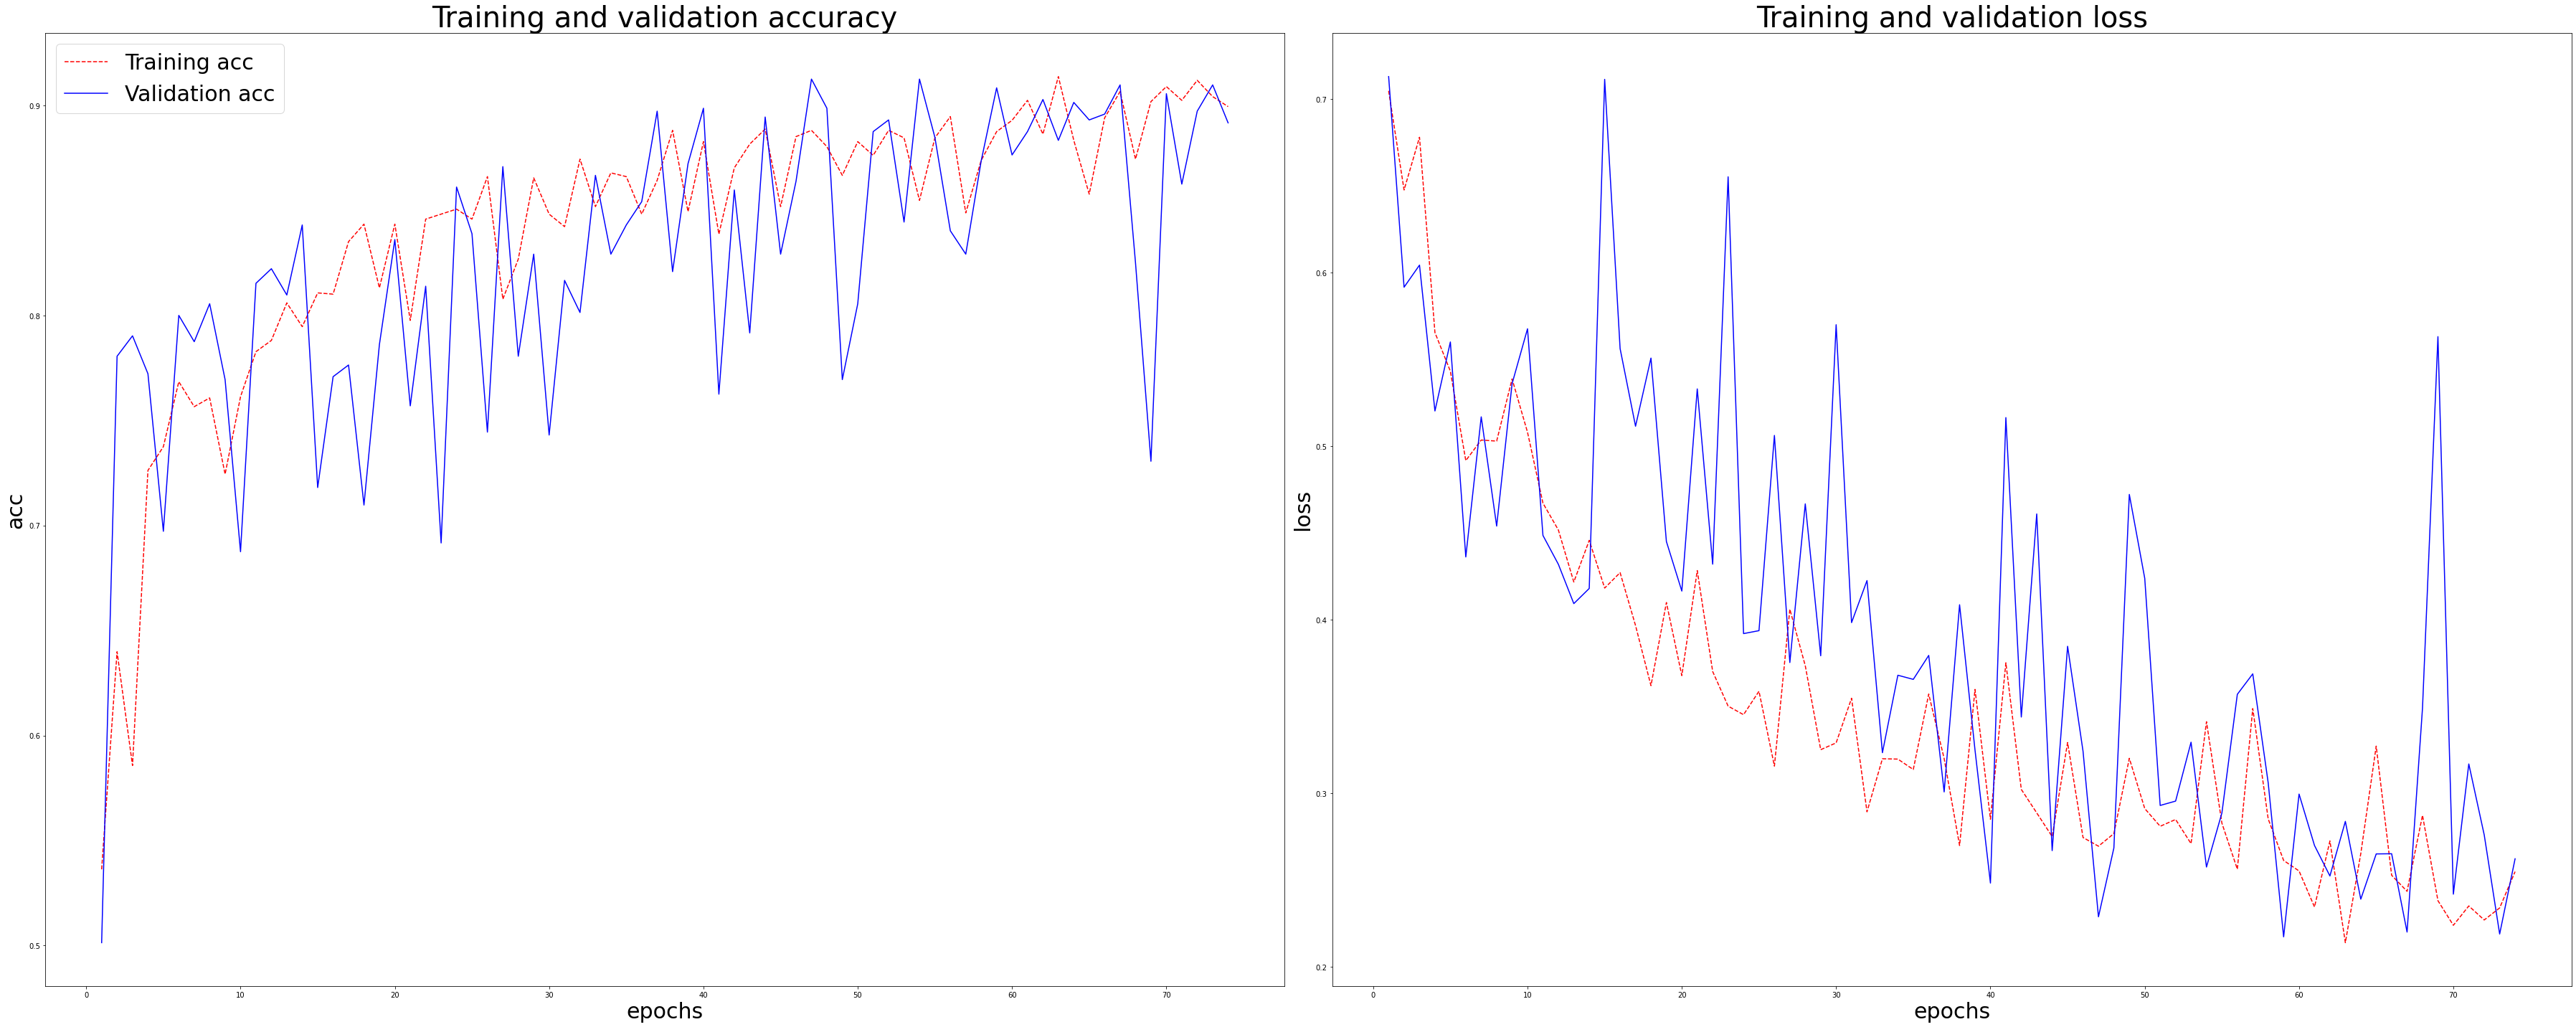

In [42]:
history=history_5_1_1_1 #history es igual al nombre en donde se hace el ajuste fit al modelo
acc = history.history['accuracy']    
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1, 1)
fig, axs = plt.subplots(1, 2,figsize=(50, 20))

axs[0].plot(epochs, acc, 'r--', label='Training acc')
axs[0].plot(epochs, val_acc,  'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy', fontsize=40)
axs[0].set_ylabel('acc', fontsize=30)
axs[0].set_xlabel('epochs', fontsize=30)
axs[0].legend( fontsize=30)

axs[1].plot(epochs, loss, 'r--' )
axs[1].plot(epochs, val_loss , 'b' )
axs[1].set_title ('Training and validation loss', fontsize=40)
axs[1].set_ylabel('loss', fontsize=30)
axs[1].set_xlabel('epochs', fontsize=30)

fig.tight_layout()
plt.show()

In [20]:
#Guardar modelo
modelosave_5_1_1_1=modelo_5_1_1_1.save('modelo_5_1_1_1.h5')

### 👆 Evaluación (X test, y test)

In [21]:
modelo_5_1_1_1.evaluate(X_test,y_test)

19/19 [==============================] - 7s 338ms/step - loss: 0.2556 - accuracy: 0.8917


[0.25561559200286865, 0.8916666507720947]

In [22]:
pred_corrida_5_1_1_1= modelo_5_1_1_1.predict(X_test)
umbral = 0.6
y_umbral_modelo_5_1_1_1 = (1*(pred_corrida_5_1_1_1)) > umbral

19/19 [==============================] - 7s 323ms/step



Accuracy	0.91
Sensitividad	0.98
Precisión	0.86


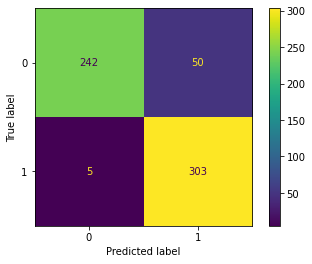

In [23]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbral_modelo_5_1_1_1),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbral_modelo_5_1_1_1),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbral_modelo_5_1_1_1),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_umbral_modelo_5_1_1_1)
plt.show()

### 👆 Evaluación con nuevas imágenes (2389 img)

In [27]:
modelo_5_1_1_1.evaluate(array_img_nuevo,etiquetas)

75/75 [==============================] - 26s 340ms/step - loss: 0.4410 - accuracy: 0.8280


[0.4410358965396881, 0.8279615044593811]

In [28]:
pred_corrida_5_1_1_1_new= modelo_5_1_1_1.predict(array_img_nuevo)
umbral = 0.6
y_umbral_modelo_5_1_1_1_new = (1*(pred_corrida_5_1_1_1_new)) > umbral

75/75 [==============================] - 28s 366ms/step



Accuracy	0.81
Sensitividad	0.85
Precisión	0.91


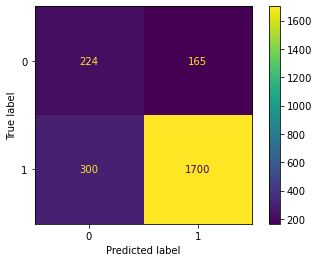

In [30]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(etiquetas, y_umbral_modelo_5_1_1_1_new),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(etiquetas, y_umbral_modelo_5_1_1_1_new),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(etiquetas, y_umbral_modelo_5_1_1_1_new),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(etiquetas, y_umbral_modelo_5_1_1_1_new)
plt.show()

### 👆 Curva ROC (AUC) 

In [8]:
from sklearn.metrics import roc_curve, auc

In [9]:
modelo_1_1 = load_model('modelo_5_1_1_1.h5')

In [10]:
y_pred_1_1= modelo_1_1.predict(X_test)

19/19 [==============================] - 7s 340ms/step


In [11]:
fpr, tpr, _ = roc_curve(y_test, y_pred_1_1)
roc_auc = auc(fpr, tpr)

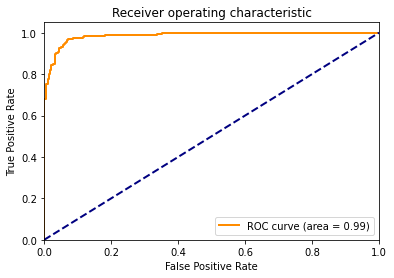

In [12]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 👆 Curva ROC con imagenes nuevas

In [11]:
modelo_new_1_1 = load_model('modelo_5_1_1_1.h5')

In [12]:
y_pred_new_1_1= modelo_new_1_1.predict(array_img_nuevo)

75/75 [==============================] - 26s 335ms/step


In [15]:
fpr_new_1_1, tpr_new_1_1, _ = roc_curve(etiquetas, y_pred_new_1_1)
roc_auc = auc(fpr_new_1_1, tpr_new_1_1)

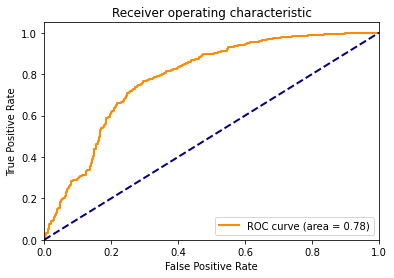

In [16]:
plt.figure()
plt.plot(fpr_new_1_1, tpr_new_1_1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Comprobamos que las imagenes etiquetadas como "sospecha (1)" han sido predecidas como tal.

In [75]:
list_etiquetas = etiquetas.tolist()
list_predic = y_umbral_modelo_prueba.tolist()


def flatten(lista):
    list_final = []
    for item in lista:
        if isinstance(item, list):
            list_final.extend(flatten(item))
        else:
            list_final.append(item)
    return list_final
list_final = flatten(list_predic)
#print(list_final)

df = pd.DataFrame({"Real":list_etiquetas,"Prediccion":list_final})

filtro = (df['Prediccion'] == True)

df2 = df.loc[filtro,'Real':'Prediccion']

## 😎 Cantidad de True Positives que se predijeron como sospecha y realmente son sospecha
df_final = df2.loc[df2['Real']==1,'Real':'Prediccion']

print(df_final)

      Real  Prediccion
0        1        True
2        1        True
5        1        True
6        1        True
7        1        True
...    ...         ...
2380     1        True
2381     1        True
2382     1        True
2385     1        True
2387     1        True

[1700 rows x 2 columns]


## 👆 Modelo 8, Prueba1

In [8]:
# Cambiar el nombre del modelo con cada prueba realizada modelo_dia_corrida_modelo_numprueba
modelo_5_2_1_1 = Sequential() 
#Add layers 
modelo_5_2_1_1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(250, 250, 3)))
modelo_5_2_1_1.add(MaxPooling2D(2, 2))
modelo_5_2_1_1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
modelo_5_2_1_1.add(MaxPooling2D(2, 2))
modelo_5_2_1_1.add(Conv2D(128, (3,3), activation='relu'))
modelo_5_2_1_1.add(MaxPooling2D(2, 2))
modelo_5_2_1_1.add(Conv2D(192, (3,3), activation='relu'))

modelo_5_2_1_1.add(Flatten())
modelo_5_2_1_1.add(Dense(100,activation= 'relu'))
modelo_5_2_1_1.add(Dense(1, activation="sigmoid",kernel_regularizer=l1_l2(0.01,0.01)))

 
adam = optimizers.Adam(learning_rate = 0.1 )
    
#compile the model
modelo_5_2_1_1.compile(loss= "binary_crossentropy", optimizer = "adam", metrics= ["accuracy"]) 

In [9]:
early_stop_5_2_1_1 = EarlyStopping(monitor= "val_loss", patience=15, mode="min") 
data_gen_entrenamiento_5_2_1_1= datagen.flow(x_entrenamiento,y_entrenamiento,batch_size=32)

In [10]:
# Train the model and store the validation loss result
history_5_2_1_1 = modelo_5_2_1_1.fit(data_gen_entrenamiento_5_2_1_1,batch_size=32,epochs=100, validation_data=(x_validacion,y_validacion),steps_per_epoch=int(np.ceil(len(x_entrenamiento)/float(32))),validation_steps=int(np.ceil(len(x_validacion)/float(32))),callbacks=[early_stop_5_2_1_1])

Epoch 1/100
53/53 [==============================] - 70s 1s/step - loss: 0.8262 - accuracy: 0.5321 - val_loss: 0.7931 - val_accuracy: 0.4986
Epoch 2/100
53/53 [==============================] - 65s 1s/step - loss: 0.7642 - accuracy: 0.5595 - val_loss: 0.7329 - val_accuracy: 0.5708
Epoch 3/100
53/53 [==============================] - 62s 1s/step - loss: 0.7299 - accuracy: 0.5702 - val_loss: 0.6992 - val_accuracy: 0.6000
Epoch 4/100
53/53 [==============================] - 63s 1s/step - loss: 0.6802 - accuracy: 0.6042 - val_loss: 0.6405 - val_accuracy: 0.6722
Epoch 5/100
53/53 [==============================] - 62s 1s/step - loss: 0.6682 - accuracy: 0.6137 - val_loss: 0.6045 - val_accuracy: 0.7514
Epoch 6/100
53/53 [==============================] - 62s 1s/step - loss: 0.6084 - accuracy: 0.6774 - val_loss: 0.5752 - val_accuracy: 0.6972
Epoch 7/100
53/53 [==============================] - 64s 1s/step - loss: 0.5711 - accuracy: 0.7190 - val_loss: 0.7331 - val_accuracy: 0.5375
Epoch 8/100
5

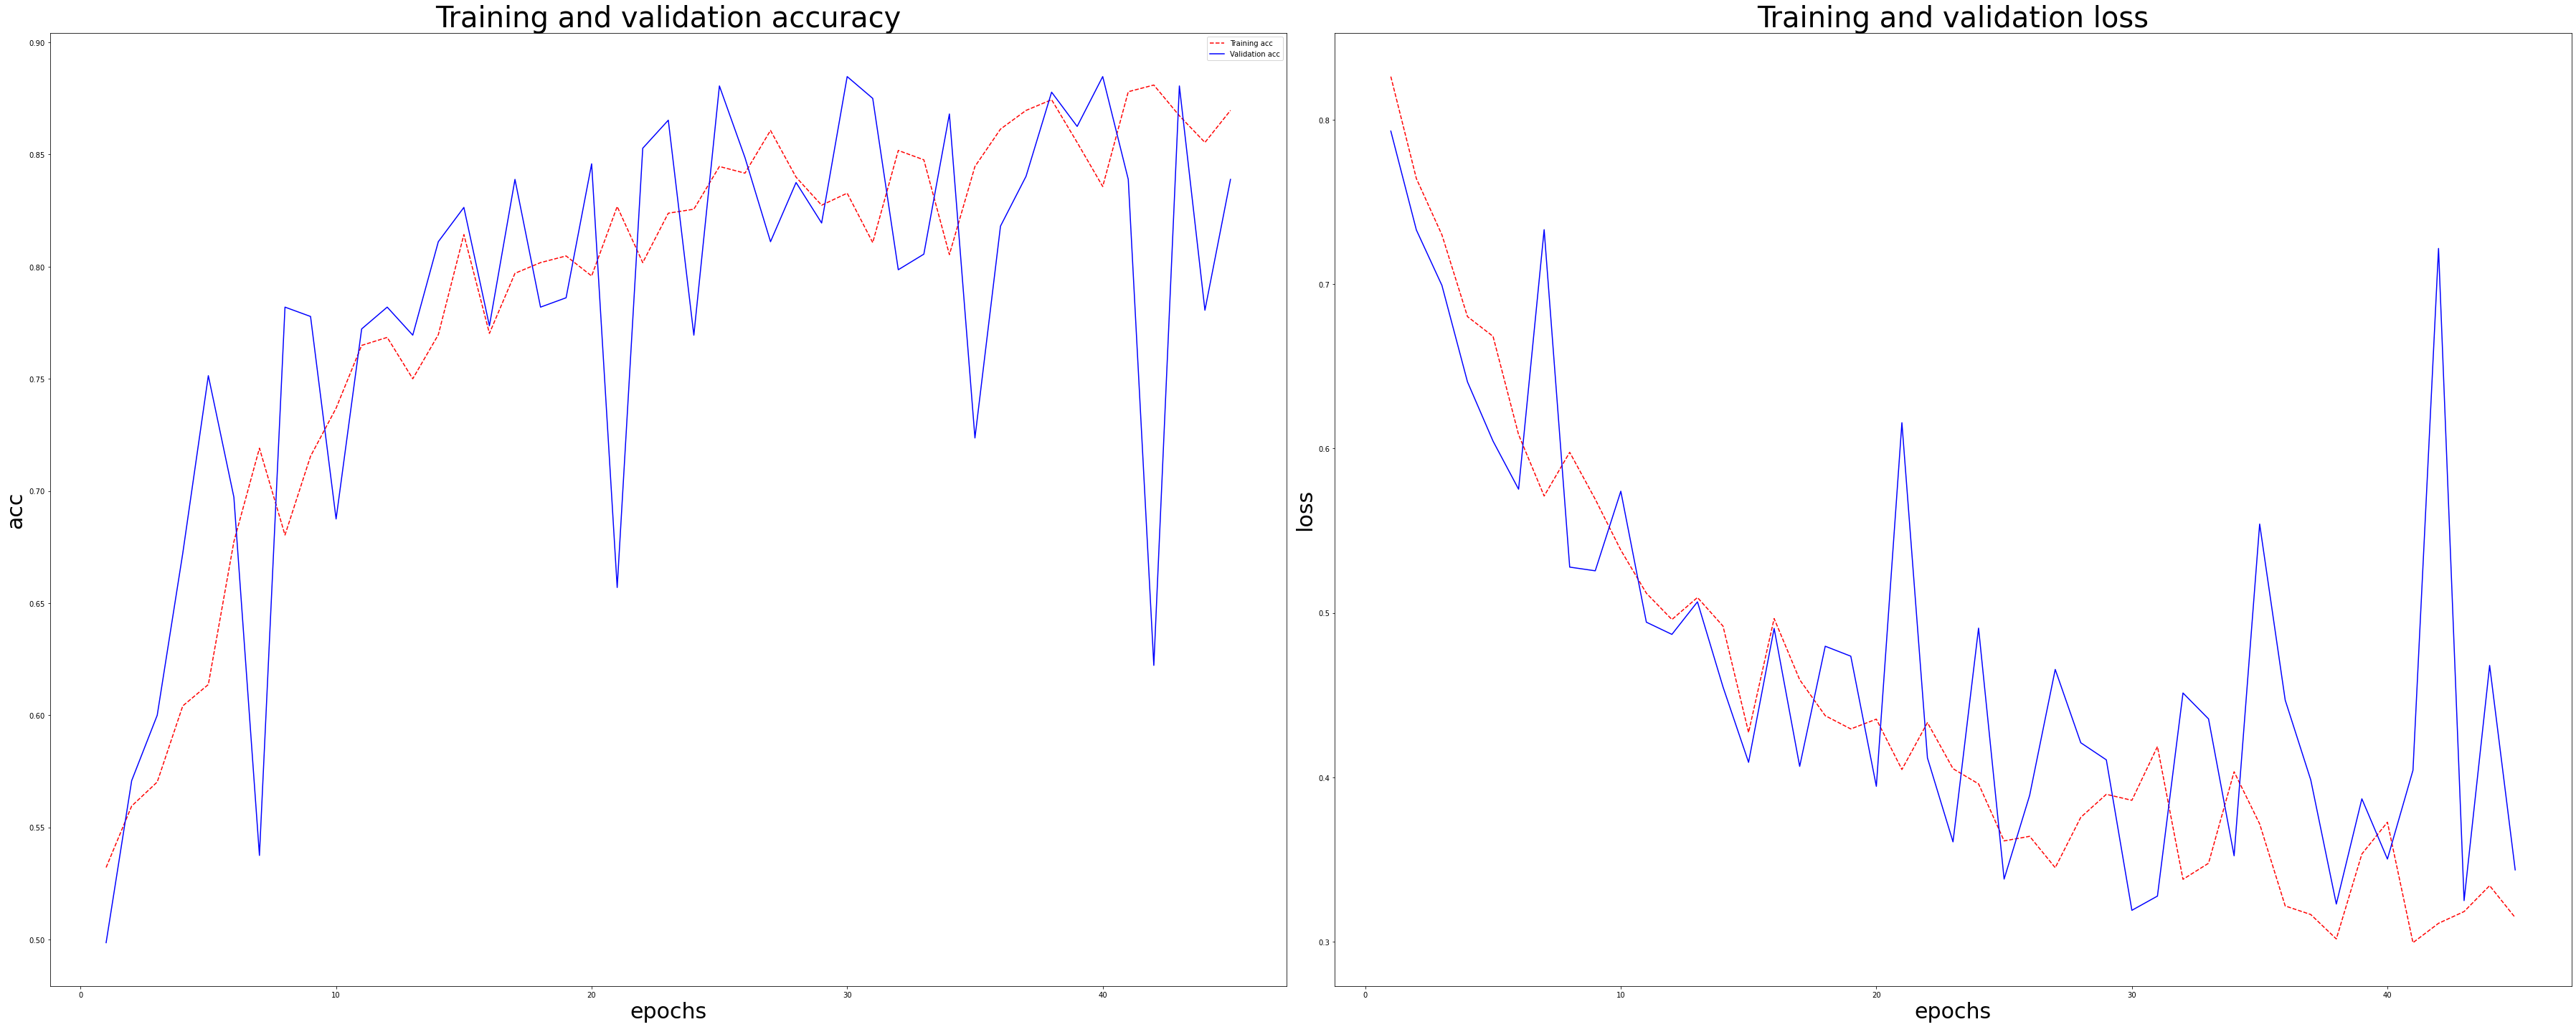

In [43]:
history=history_5_2_1_1 #history es igual al nombre en donde se hace el ajuste fit al modelo
acc = history.history['accuracy']    
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1, 1)
fig, axs = plt.subplots(1, 2,figsize=(50, 20))

axs[0].plot(epochs, acc, 'r--', label='Training acc')
axs[0].plot(epochs, val_acc,  'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy',fontsize=40)
axs[0].set_ylabel('acc',fontsize=30)
axs[0].set_xlabel('epochs',fontsize=30)
axs[0].legend()

axs[1].plot(epochs, loss, 'r--' )
axs[1].plot(epochs, val_loss , 'b' )
axs[1].set_title ('Training and validation loss',fontsize=40)
axs[1].set_ylabel('loss',fontsize=30)
axs[1].set_xlabel('epochs',fontsize=30)

fig.tight_layout()
plt.show()

In [12]:
#Guardar modelo
modelosave_5_2_1_1=modelo_5_2_1_1.save('modelo_5_2_1_1.h5')

### 👆 Evaluacion (X_test, y_test)

In [13]:
modelo_5_2_1_1.evaluate(X_test,y_test)

19/19 [==============================] - 6s 320ms/step - loss: 0.2949 - accuracy: 0.8500


[0.29487985372543335, 0.8500000238418579]

In [14]:
pred_corrida_5_2_1_1= modelo_5_2_1_1.predict(X_test)
umbral = 0.6
y_umbral_modelo_5_2_1_1 = (1*(pred_corrida_5_2_1_1)) > umbral

19/19 [==============================] - 6s 325ms/step



Accuracy	0.89
Sensitividad	0.96
Precisión	0.85


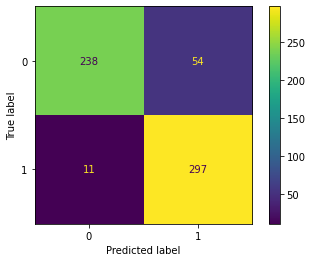

In [15]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbral_modelo_5_2_1_1),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbral_modelo_5_2_1_1),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbral_modelo_5_2_1_1),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_umbral_modelo_5_2_1_1)
plt.show()

### 👆 Evaluación con nuevas imágenes (2389 img)

In [31]:
modelo_5_2_1_1.evaluate(array_img_nuevo,etiquetas)

75/75 [==============================] - 23s 307ms/step - loss: 0.5034 - accuracy: 0.7777


[0.5034230947494507, 0.7777312397956848]

In [32]:
pred_corrida_5_2_1_1= modelo_5_2_1_1.predict(array_img_nuevo)
umbral = 0.6
y_umbral_modelo_5_2_1_1 = (1*(pred_corrida_5_2_1_1)) > umbral

75/75 [==============================] - 25s 338ms/step



Accuracy	0.74
Sensitividad	0.76
Precisión	0.91


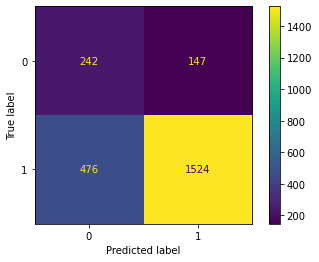

In [33]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(etiquetas, y_umbral_modelo_5_2_1_1),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(etiquetas, y_umbral_modelo_5_2_1_1),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(etiquetas, y_umbral_modelo_5_2_1_1),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(etiquetas, y_umbral_modelo_5_2_1_1)
plt.show()

In [13]:
modelo_2_1 = load_model('modelo_5_2_1_1.h5')

### 👆 Curva ROC (X_test)

In [14]:
y_pred_2_1= modelo_2_1.predict(X_test)

19/19 [==============================] - 6s 317ms/step


In [15]:
fpr_2_1, tpr_2_1, _ = roc_curve(y_test, y_pred_2_1)
roc_auc = auc(fpr_2_1, tpr_2_1)

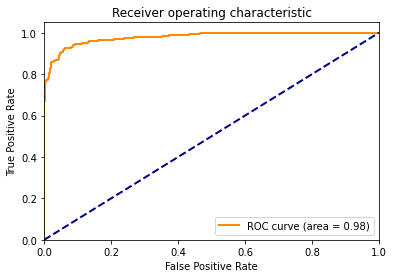

In [16]:
plt.figure()
plt.plot(fpr_2_1, tpr_2_1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## ✌️ Modelo 7,Prueba2

In [30]:
#Cambiar el nombre del modelo con cada prueba realizada, modelo_dia_corrida_modelo_numprueba
modelo_9_1_2_1 = Sequential() 
#Add layers 
modelo_9_1_2_1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(250, 250, 3)))
modelo_9_1_2_1.add(MaxPooling2D(2, 2))
modelo_9_1_2_1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
modelo_9_1_2_1.add(MaxPooling2D(2, 2))
modelo_9_1_2_1.add(Conv2D(128, (3,3), activation='relu'))
modelo_9_1_2_1.add(MaxPooling2D(2, 2))
modelo_9_1_2_1.add(Conv2D(192, (3,3), activation='relu'))

modelo_9_1_2_1.add(Flatten())
modelo_9_1_2_1.add(Dense(100,activation= 'relu'))
modelo_9_1_2_1.add(Dense(1, activation="sigmoid",kernel_regularizer=l2(0.01)))

#declare adam optimizer 
adam = optimizers.Adam(learning_rate = 0.1 )


#compile the model
modelo_9_1_2_1.compile(loss= "binary_crossentropy", optimizer = "adam", metrics= ["accuracy"])

In [31]:
early_stop_9_1_2_1 = EarlyStopping(monitor= "val_loss", patience=15, mode="min") 
data_gen_entrenamiento_9_1_2_1= datagen.flow(x_entrenamiento,y_entrenamiento,batch_size=32)

In [32]:
# Train the model and store the validation loss result
history_9_1_2_1 = modelo_9_1_2_1.fit(data_gen_entrenamiento_9_1_2_1,batch_size=32,epochs=100, validation_data=(x_validacion,y_validacion),steps_per_epoch=int(np.ceil(len(x_entrenamiento)/float(32))),validation_steps=int(np.ceil(len(x_validacion)/float(32))),callbacks=[early_stop_9_1_2_1])

Epoch 1/100
53/53 [==============================] - 85s 2s/step - loss: 0.7079 - accuracy: 0.5244 - val_loss: 0.7026 - val_accuracy: 0.5972
Epoch 2/100
53/53 [==============================] - 66s 1s/step - loss: 0.6975 - accuracy: 0.5351 - val_loss: 0.6848 - val_accuracy: 0.7139
Epoch 3/100
53/53 [==============================] - 64s 1s/step - loss: 0.6698 - accuracy: 0.6107 - val_loss: 0.6663 - val_accuracy: 0.5153
Epoch 4/100
53/53 [==============================] - 63s 1s/step - loss: 0.6057 - accuracy: 0.6583 - val_loss: 0.5836 - val_accuracy: 0.6639
Epoch 5/100
53/53 [==============================] - 62s 1s/step - loss: 0.5589 - accuracy: 0.7137 - val_loss: 0.5224 - val_accuracy: 0.7583
Epoch 6/100
53/53 [==============================] - 64s 1s/step - loss: 0.6287 - accuracy: 0.6440 - val_loss: 0.5459 - val_accuracy: 0.7806
Epoch 7/100
53/53 [==============================] - 63s 1s/step - loss: 0.5518 - accuracy: 0.7274 - val_loss: 0.5025 - val_accuracy: 0.7861
Epoch 8/100
5

In [34]:
modelosave_9_1_2_1 = modelo_9_1_2_1.save('modelo_9_1_2_1.h5')

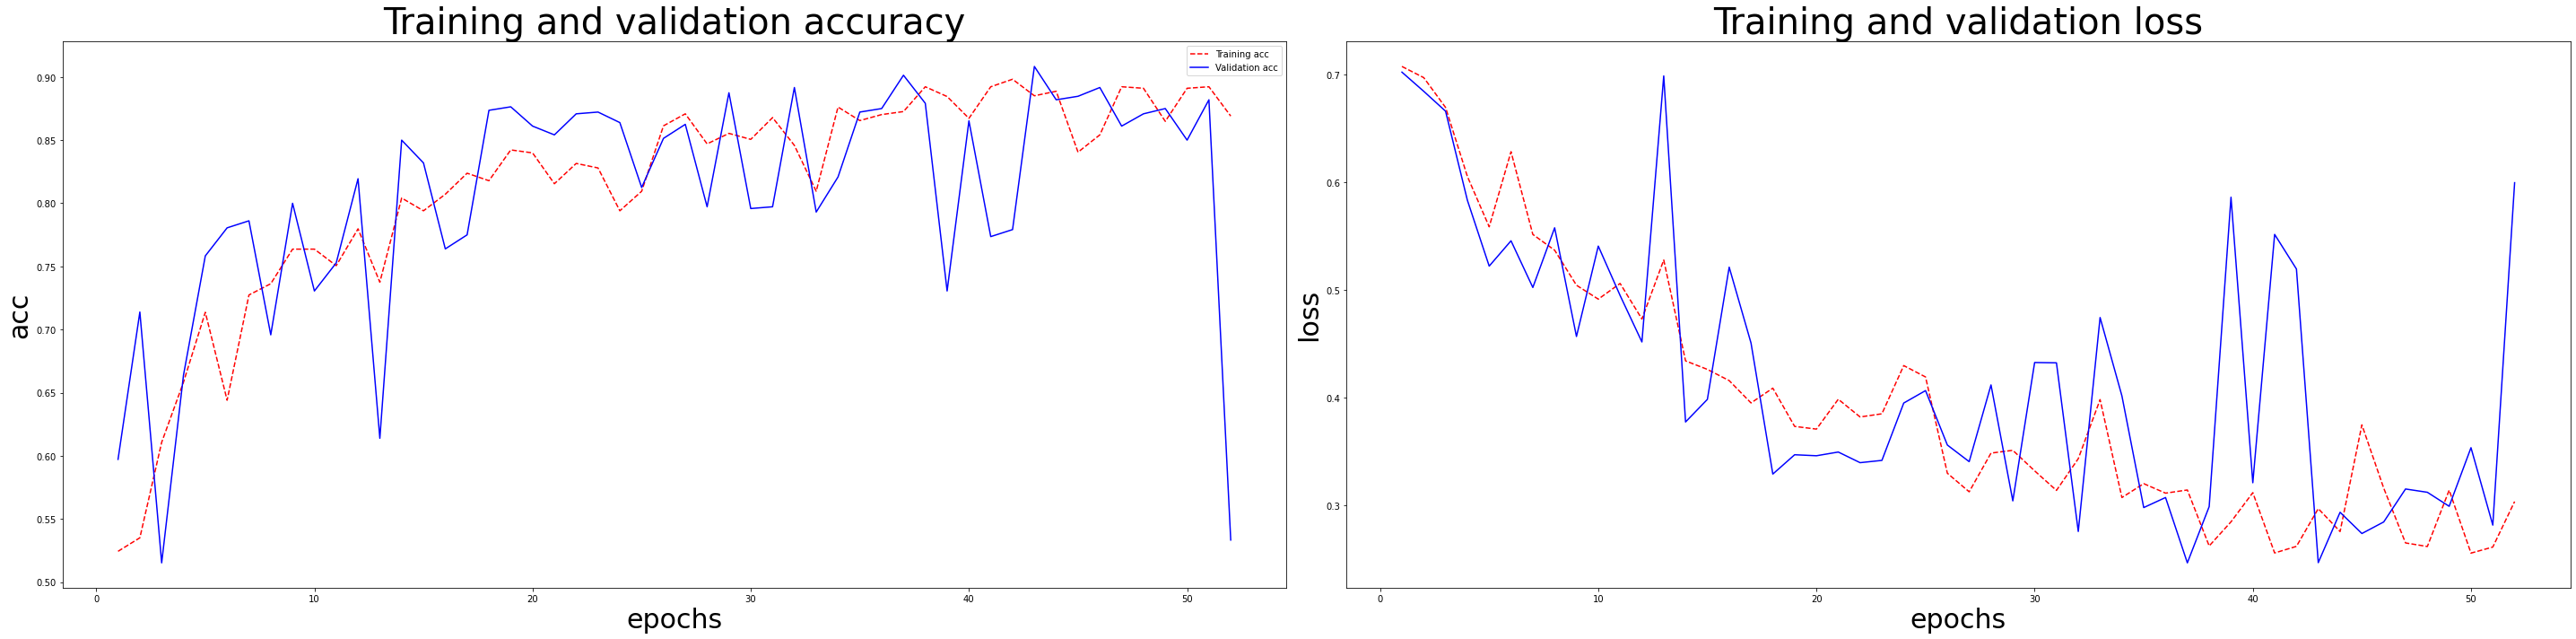

In [35]:
history=history_9_1_2_1 #history es igual al nombre en donde se hace el ajuste fit al modelo
acc = history.history['accuracy']    
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1, 1)
fig, axs = plt.subplots(1, 2,figsize=(40, 10))

axs[0].plot(epochs, acc, 'r--', label='Training acc')
axs[0].plot(epochs, val_acc,  'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy',fontsize = 40)
axs[0].set_ylabel('acc',fontsize=30)
axs[0].set_xlabel('epochs',fontsize=30)
axs[0].legend()

axs[1].plot(epochs, loss, 'r--' )
axs[1].plot(epochs, val_loss , 'b' )
axs[1].set_title ('Training and validation loss',fontsize = 40)
axs[1].set_ylabel('loss',fontsize=30)
axs[1].set_xlabel('epochs',fontsize=30)

fig.tight_layout()
plt.show()


Accuracy	0.88
Sensitividad	0.98
Precisión	0.83


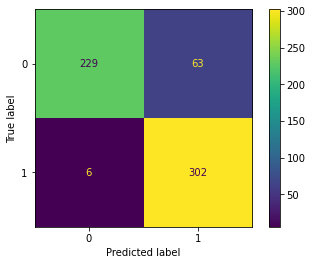

In [38]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbral_modelo_4_1_2_2),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbral_modelo_4_1_2_2),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbral_modelo_4_1_2_2),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_umbral_modelo_4_1_2_2)
plt.show()

## Probamos este modelo con las nuevas imagenes

In [41]:
modelo_4_1_2_2.evaluate(array_img_nuevo,etiquetas)

75/75 [==============================] - 26s 337ms/step - loss: 0.4187 - accuracy: 0.8397


[0.4186728000640869, 0.83968186378479]

In [42]:
pred_corrida_modelo_4_1_2_2= modelo_4_1_2_2.predict(array_img_nuevo)
umbral = 0.6
y_umbral_modelo_4_1_2_2 = (1*(pred_corrida_modelo_4_1_2_2)) > umbral

75/75 [==============================] - 24s 319ms/step



Accuracy	0.82
Sensitividad	0.88
Precisión	0.9


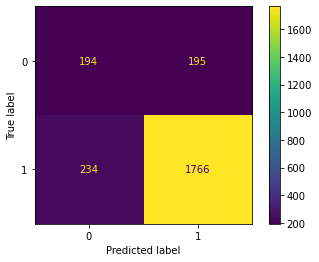

In [43]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(etiquetas, y_umbral_modelo_4_1_2_2),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(etiquetas, y_umbral_modelo_4_1_2_2),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(etiquetas, y_umbral_modelo_4_1_2_2),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(etiquetas, y_umbral_modelo_4_1_2_2)
plt.show()

### ✌️Curva ROC (AUC) con X_test, y_test

In [36]:
y_pred_1_2_2= modelo_9_1_2_1.predict(X_test)

19/19 [==============================] - 6s 330ms/step


In [76]:
fpr_1_2_2, tpr_1_2_2, _ = roc_curve(y_test, y_pred_1_2_2)
roc_auc = auc(fpr_1_2_2, tpr_1_2_2)

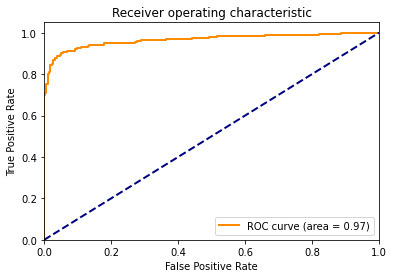

In [39]:
plt.figure()
plt.plot(fpr_1_2_2, tpr_1_2_2, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## ✌️Curva ROC con imagenes nuevas

In [17]:
model_new_1_2=load_model('modelo_9_1_2_1.h5')

In [18]:
y_pred_new_1_2= model_new_1_2.predict(array_img_nuevo)

75/75 [==============================] - 26s 340ms/step


In [19]:
fpr_new_1_2, tpr_new_1_2, _ = roc_curve(etiquetas, y_pred_new_1_2)
roc_auc = auc(fpr_new_1_2, tpr_new_1_2)

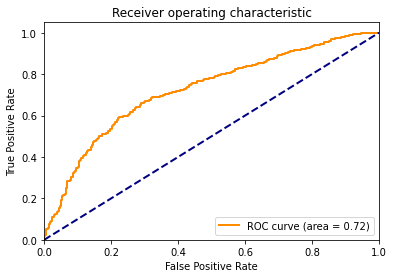

In [20]:
plt.figure()
plt.plot(fpr_new_1_2, tpr_new_1_2, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## ✌️ Modelo 8, Prueba2

In [17]:
# Cambiar el nombre del modelo con cada prueba realizada modelo_dia_corrida_modelo_numprueba
modelo_3_2_1_2 = Sequential() 
#Add layers 
modelo_3_2_1_2.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(250, 250, 3)))
modelo_3_2_1_2.add(MaxPooling2D(2, 2))
modelo_3_2_1_2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
modelo_3_2_1_2.add(MaxPooling2D(2, 2))
modelo_3_2_1_2.add(Conv2D(128, (3,3), activation='relu'))
modelo_3_2_1_2.add(MaxPooling2D(2, 2))
modelo_3_2_1_2.add(Conv2D(192, (3,3), activation='relu'))

modelo_3_2_1_2.add(Flatten())
modelo_3_2_1_2.add(Dense(100,activation= 'relu'))
modelo_3_2_1_2.add(Dense(1, activation="sigmoid",kernel_regularizer=l1_l2(0.01,0.01)))

#declare adam optimizer with learning rate of 0.001 
adam = optimizers.Adam(learning_rate = 0.1 )
    
#compile the model
modelo_3_2_1_2.compile(loss= "binary_crossentropy", optimizer = "adam", metrics= ["accuracy"]) 

In [18]:
early_stop_3_2_1_2 = EarlyStopping(monitor= "val_loss", patience=15, mode="min") 
data_gen_entrenamiento_3_2_1_2= datagen.flow(x_entrenamiento,y_entrenamiento,batch_size=32)

In [19]:
# Train the model and store the validation loss result
history_3_2_1_2 = modelo_3_2_1_2.fit(data_gen_entrenamiento_3_2_1_2,batch_size=32,epochs=100, validation_data=(x_validacion,y_validacion),steps_per_epoch=int(np.ceil(len(x_entrenamiento)/float(32))),validation_steps=int(np.ceil(len(x_validacion)/float(32))),callbacks=[early_stop_3_2_1_2])

Epoch 1/100
53/53 [==============================] - 64s 1s/step - loss: 0.8113 - accuracy: 0.5244 - val_loss: 0.7579 - val_accuracy: 0.7194
Epoch 2/100
53/53 [==============================] - 64s 1s/step - loss: 0.7201 - accuracy: 0.6464 - val_loss: 0.6682 - val_accuracy: 0.7069
Epoch 3/100
53/53 [==============================] - 62s 1s/step - loss: 0.6796 - accuracy: 0.6560 - val_loss: 0.6359 - val_accuracy: 0.7236
Epoch 4/100
53/53 [==============================] - 62s 1s/step - loss: 0.6494 - accuracy: 0.6619 - val_loss: 0.6581 - val_accuracy: 0.6569
Epoch 5/100
53/53 [==============================] - 62s 1s/step - loss: 0.6359 - accuracy: 0.6708 - val_loss: 0.6490 - val_accuracy: 0.6611
Epoch 6/100
53/53 [==============================] - 63s 1s/step - loss: 0.6293 - accuracy: 0.6702 - val_loss: 0.7964 - val_accuracy: 0.5042
Epoch 7/100
53/53 [==============================] - 63s 1s/step - loss: 0.6151 - accuracy: 0.6899 - val_loss: 0.6233 - val_accuracy: 0.7111
Epoch 8/100
5

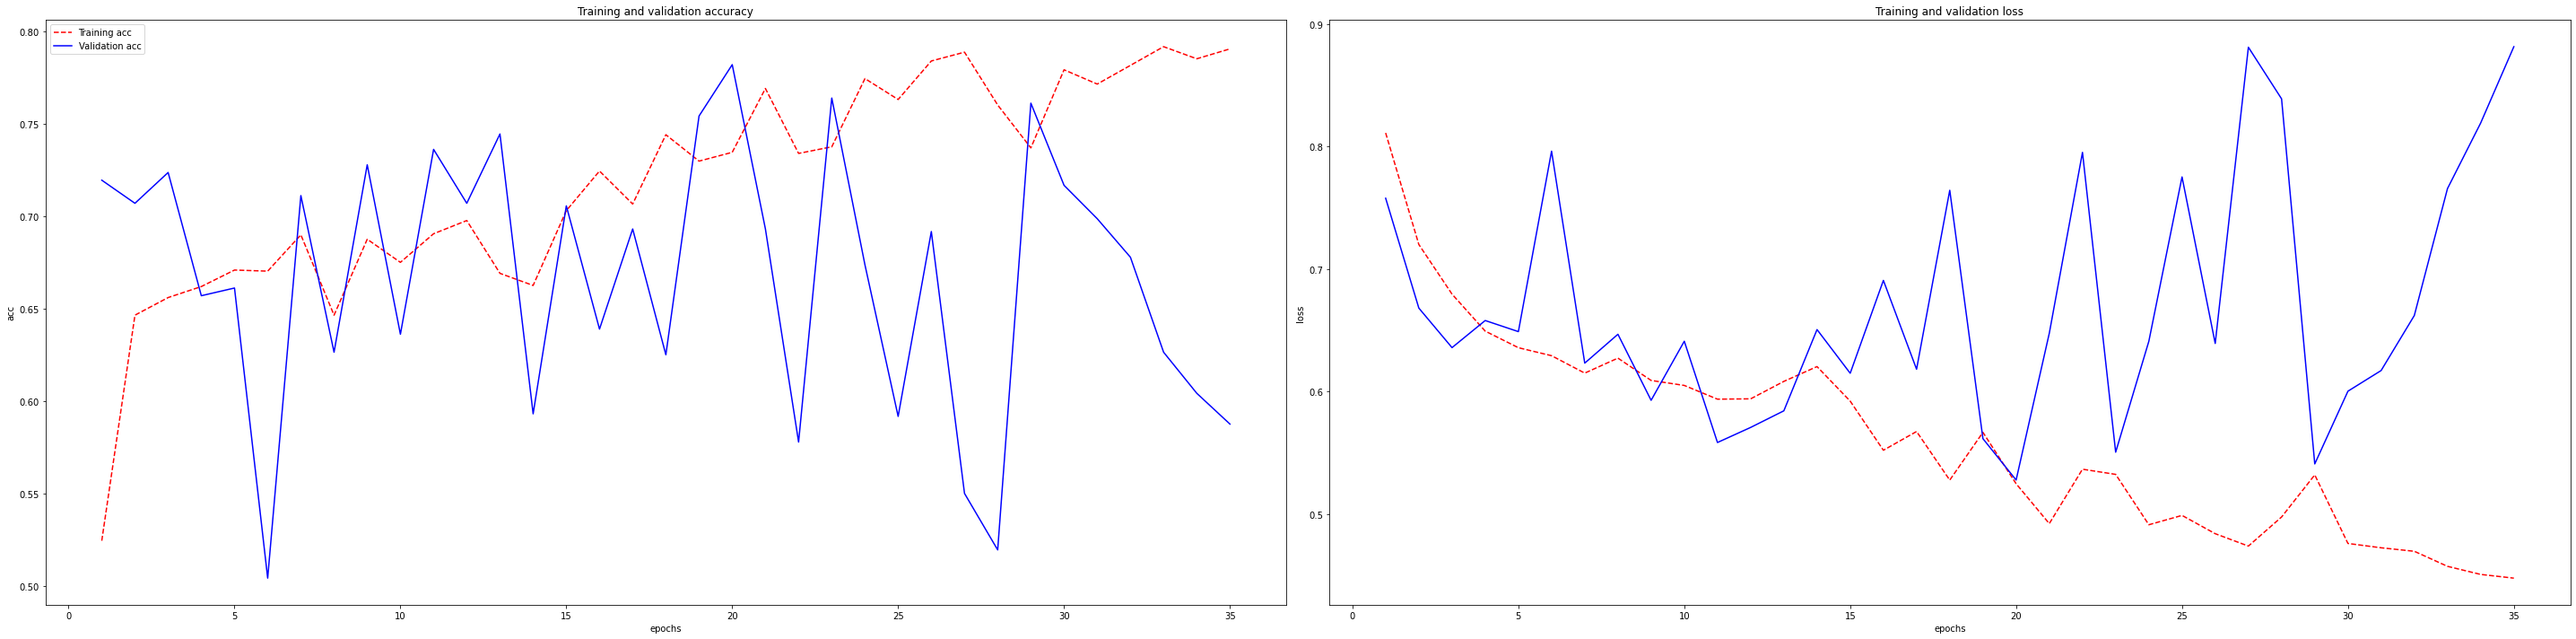

In [20]:
history=history_3_2_1_2 #history es igual al nombre en donde se hace el ajuste fit al modelo
acc = history.history['accuracy']    
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1, 1)
fig, axs = plt.subplots(1, 2,figsize=(40, 10))

axs[0].plot(epochs, acc, 'r--', label='Training acc')
axs[0].plot(epochs, val_acc,  'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].set_ylabel('acc')
axs[0].set_xlabel('epochs')
axs[0].legend()

axs[1].plot(epochs, loss, 'r--' )
axs[1].plot(epochs, val_loss , 'b' )
axs[1].set_title ('Training and validation loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epochs')

fig.tight_layout()
plt.show()

In [21]:
#Guardar modelo
modelosave_3_2_1_2=modelo_3_2_1_2.save('modelo_3_2_1_2.h5')

### ✌️ Evaluación (X_test, y_test)

In [22]:
modelo_3_2_1_2.evaluate(X_test,y_test)

19/19 [==============================] - 6s 317ms/step - loss: 0.8242 - accuracy: 0.6067


[0.8242269158363342, 0.6066666841506958]

In [24]:
pred_corrida_3_2_1_2= modelo_3_2_1_2.predict(X_test)
umbral = 0.6
y_umbral_modelo_3_2_1_2 = (1*(pred_corrida_3_2_1_2)) > umbral

19/19 [==============================] - 6s 312ms/step



Accuracy	0.64
Sensitividad	1.0
Precisión	0.59


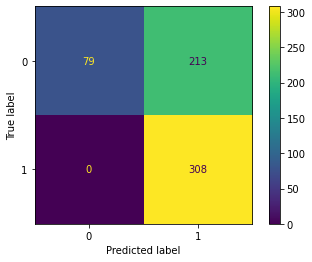

In [25]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_test, y_umbral_modelo_3_2_1_2),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(y_test, y_umbral_modelo_3_2_1_2),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(y_test, y_umbral_modelo_3_2_1_2),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_umbral_modelo_3_2_1_2)
plt.show()

### ✌️ Evaluación con nuevas imagenes

In [44]:
modelo_3_2_1_2.evaluate(array_img_nuevo,etiquetas)

75/75 [==============================] - 23s 309ms/step - loss: 0.4256 - accuracy: 0.8514


[0.42555177211761475, 0.8514022827148438]

In [45]:
pred_corrida_modelo_3_2_1_2= modelo_3_2_1_2.predict(array_img_nuevo)
umbral = 0.6
y_umbral_modelo_3_2_1_2 = (1*(pred_corrida_modelo_3_2_1_2)) > umbral

75/75 [==============================] - 24s 310ms/step



Accuracy	0.86
Sensitividad	0.99
Precisión	0.86


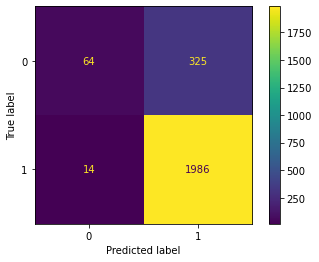

In [46]:
#MOSTRAMOS LA MATRIZ DE CONFUSION
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(etiquetas, y_umbral_modelo_3_2_1_2),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(etiquetas, y_umbral_modelo_3_2_1_2),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(etiquetas, y_umbral_modelo_3_2_1_2),2)))    
metrics.ConfusionMatrixDisplay.from_predictions(etiquetas, y_umbral_modelo_3_2_1_2)
plt.show()

In [40]:
#Cargar modelo
model_2_2=load_model('modelo_3_2_1_2.h5')

### ✌️ Curva ROC (AUC)

In [42]:
y_predic_2_2 = model_2_2.predict(X_test)

19/19 [==============================] - 6s 317ms/step


In [43]:
fpr_2_2, tpr_2_2, _ = roc_curve(y_test, y_predic_2_2)
roc_auc = auc(fpr_2_2, tpr_2_2)

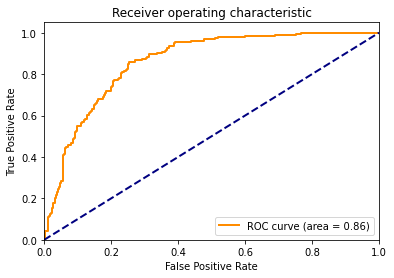

In [44]:
plt.figure()
plt.plot(fpr_2_2, tpr_2_2, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()